In [1]:
import matplotlib.pyplot as plt
import nltk
# download this if havent already
# nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

ImportError: cannot import name 'roc_score' from 'sklearn.metrics' (/Users/cheon/anaconda3/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

In [2]:
pd.options.display.max_colwidth = 280

In [3]:
df = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# checking the class distribution
df.target.sum()/df.shape[0]

0.4296597924602653

### keywords

In [6]:
df['keyword'] = df.keyword.str.replace('%20', ' ')
# must call on the series outside of where instead of the whole df
df['keyword'] = df.keyword.where(df.keyword.notna(), None)

### locations

In [7]:
df['location'] = df.location.where(df.location.notna(), None)
df['location'] = df.location.str.lower()
# this might not be as important
df['location'] = df.location.str.replace('[^a-zA-Z]', '')

### text

In [8]:
def text_normalization(series):
    # normalization of the text and replacing any hastags and nonalphanumeric chars
    temp = series.str.lower()
    temp = temp.str.replace('[^a-zA-Z0-9, ]', '')
    temp = temp.str.split()
    # removing the stopwords in the text and turning the entry to a list of words
    stop = stopwords.words('english')
    temp = temp.apply(lambda words: [word for word in words if word not in stop])
    return temp

### glove word embedding

In [9]:
def load_glove(filename):
    """
    Read all lines from the indicated file and return a dictionary
    mapping word:vector where vectors are of numpy `array` type.
    GloVe file lines are of the form:

    the 0.418 0.24968 -0.41242 0.1217 ...

    So split each line on spaces into a list; the first element is the word
    and the remaining elements represent factor components. The length of the vector
    should not matter; read vectors of any length.
    """

    #open and read in the files in lines
    with open(filename, 'r') as f:
        word_vecs = f.readlines()

    #create the dictionary where the word is key and the value is the word vector
    mapping = {}
    for word_vec in word_vecs:
        temp = word_vec.split()
        mapping[temp[0]] = np.array(temp[1:], dtype = float)
    return mapping

In [25]:
word_dict = load_glove('glove.twitter.27B/glove.twitter.27B.50d.txt')

In [11]:
def avg_doc2vec(text, gloves=word_dict):
    """
    Return the average word vector for the tweet. Sum the word vectors
    for each word and then divide by the number of words. Ignore words
    not in gloves.
    """
    
    vec = np.zeros(len(text))
    # flag for if its the first word
    flag = 1
    # iterate through the list of words to sum up the word vectors in the doc
    for word in text:
        if word in gloves.keys():
            if flag == 1:
                vec = gloves[word]
                flag = 0
            else:
                vec = np.add(vec, gloves[word])

    # return the average vector
    return vec/len(text)

In [12]:
def min_max_doc2vec(text, gloves=word_dict):
    """
    Return the min max concatenation of word vectors for the tweet.
    Ignore words not in gloves.
    """
    #vec = np.zeros(len(text*2))
    min_vec = np.zeros(len(text))
    max_vec = np.zeros(len(text))
    # flag for if its the first word
    flag = 1
    
    for word in text:
        if word in gloves.keys():
            if flag == 1:
                min_vec = gloves[word]
                max_vec = gloves[word]
                flag = 0
            else:
                min_vec = np.minimum(min_vec, gloves[word])
                max_vec = np.maximum(max_vec, gloves[word])
                
    # return the concatenation of the two vectors
    return np.concatenate((min_vec, max_vec))

In [13]:
def create_data(dataframe, length):
    # turning the series of word embedding vectors into a nd array
    X = np.empty([dataframe.shape[0], length])
    y = np.empty([dataframe.shape[0]])
    for idx, row in dataframe.iterrows():
        try:
            X[idx, :] = row.text
        except:
            X[idx, :] = np.zeros(length)
        y[idx] = row.target
    return (X, y)

### Average word vectors

In [96]:
# normalizing the text and creating an average doc2vec
df = pd.read_csv("data/train.csv")
df['text'] = text_normalization(df.text)
df['text'] = df.text.apply(avg_doc2vec)
# creating the data and splitting it
X, y = create_data(df, 50)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [97]:
# model training with Gaussian Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [24]:
# evaluation metrics w/ 100d
print(f"Training Accuracy w/ Guassian NB: {accuracy_score(y_train, nb.predict(X_train))}")
print(f"Testing Accuracy w/ Guassian NB: {accuracy_score(y_test, nb.predict(X_test))}")

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:434: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:436: RuntimeWarning: divide by zero encountered in true_divide
  (self.sigma_[i, :]), 1)
/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:436: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)


Training Accuracy w/ Guassian NB: 0.5694517428621475
Testing Accuracy w/ Guassian NB: 0.5730042016806722


/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:434: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:436: RuntimeWarning: divide by zero encountered in true_divide
  (self.sigma_[i, :]), 1)
/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:436: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)


In [20]:
# evaluation metrics w/ 200d
print(f"Training Accuracy w/ Guassian NB: {accuracy_score(y_train, nb.predict(X_train))}")
print(f"Testing Accuracy w/ Guassian NB: {accuracy_score(y_test, nb.predict(X_test))}")

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:434: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:436: RuntimeWarning: divide by zero encountered in true_divide
  (self.sigma_[i, :]), 1)
/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:436: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)


Training Accuracy w/ Guassian NB: 0.5694517428621475


/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:434: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:436: RuntimeWarning: divide by zero encountered in true_divide
  (self.sigma_[i, :]), 1)
/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:436: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)


Testing Accuracy w/ Guassian NB: 0.5730042016806722


In [98]:
# evaluation metrics w/ 50d
print(f"Training Accuracy w/ Guassian NB: {accuracy_score(y_train, nb.predict(X_train))}")
print(f"Testing Accuracy w/ Guassian NB: {accuracy_score(y_test, nb.predict(X_test))}")

Training Accuracy w/ Guassian NB: 0.766333858819408
Testing Accuracy w/ Guassian NB: 0.773109243697479


In [99]:
# evaluation metrics w/ 50d
print(f"Training F1-Score w/ Guassian NB: {f1_score(y_train, nb.predict(X_train))}")
print(f"Testing F1-Score w/ Guassian NB: {f1_score(y_test, nb.predict(X_test))}")

Training F1-Score w/ Guassian NB: 0.7393513091051193
Testing F1-Score w/ Guassian NB: 0.7485448195576252


In [100]:
print(classification_report(y_train, nb.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.81      0.76      0.79      3251
         1.0       0.71      0.77      0.74      2458

    accuracy                           0.77      5709
   macro avg       0.76      0.77      0.76      5709
weighted avg       0.77      0.77      0.77      5709



In [101]:
nb_fpr, nb_tpr, thresholds = roc_curve(y_train, nb.predict_proba(X_train)[:,1])

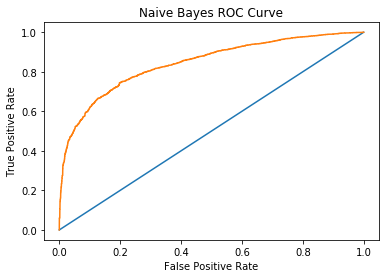

In [102]:
plt.plot([0,1], [0,1])
plt.plot(nb_fpr, nb_tpr)
plt.title('Naive Bayes ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [72]:
# evaluation metrics w/ 25d
print(f"Training Accuracy w/ Guassian NB: {accuracy_score(y_train, nb.predict(X_train))}")
print(f"Testing Accuracy w/ Guassian NB: {accuracy_score(y_test, nb.predict(X_test))}")

Training Accuracy w/ Guassian NB: 0.7412856892625679
Testing Accuracy w/ Guassian NB: 0.7589285714285714


In [103]:
# trying a logistic regression
log = LogisticRegression(solver='lbfgs', max_iter=200)
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
# evaluation metrics w/ 50d
print(f"Training Accuracy w/ Logistic Regression: {accuracy_score(y_train, log.predict(X_train))}")
print(f"Testing Accuracy w/ Logistic Regression: {accuracy_score(y_test, log.predict(X_test))}")

Training Accuracy w/ Logistic Regression: 0.792608162550359
Testing Accuracy w/ Logistic Regression: 0.792016806722689


In [105]:
# evaluation metrics w/ 50d
print(f"Training F1-Score w/ Logistic Regression: {f1_score(y_train, log.predict(X_train))}")
print(f"Testing F1-Score w/ Logistic Regression: {f1_score(y_test, log.predict(X_test))}")

Training F1-Score w/ Logistic Regression: 0.745595186935969
Testing F1-Score w/ Logistic Regression: 0.7435233160621761


In [63]:
log_fpr, log_tpr, thresholds = roc_curve(y_train, log.predict_proba(X_train)[:,1])

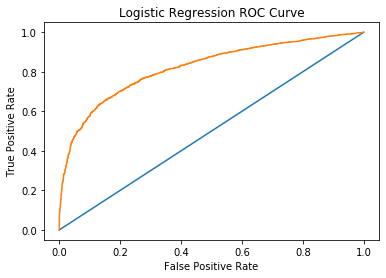

In [64]:
plt.plot([0,1], [0,1])
plt.plot(fpr, tpr)
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Min Max word vectors

In [33]:
df = pd.read_csv("data/train.csv")
df['text'] = text_normalization(df.text)
df['text'] = df.text.apply(min_max_doc2vec)
df['text'] = df.text.apply(lambda x: x.reshape((1,-1)).squeeze())

In [34]:
# creating the data and splitting it
X, y = create_data(df, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
# model training with Gaussian Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [36]:
# evaluation metrics w/ 50d
print(f"Training Accuracy w/ Guassian NB: {accuracy_score(y_train, nb.predict(X_train))}")
print(f"Testing Accuracy w/ Guassian NB: {accuracy_score(y_test, nb.predict(X_test))}")

Training Accuracy w/ Guassian NB: 0.7286740234717113
Testing Accuracy w/ Guassian NB: 0.7363445378151261


In [125]:
# evaluation metrics w/ 25d
print(f"Training Accuracy w/ Guassian NB: {accuracy_score(y_train, nb.predict(X_train))}")
print(f"Testing Accuracy w/ Guassian NB: {accuracy_score(y_test, nb.predict(X_test))}")

Training Accuracy w/ Guassian NB: 0.720091084252934
Testing Accuracy w/ Guassian NB: 0.7379201680672269


### Out of sample

In [72]:
def create_sub(dataframe, length):
    # turning the series of word embedding vectors into a nd array
    X = np.empty([dataframe.shape[0], length])
    y = np.empty([dataframe.shape[0]])
    for idx, row in dataframe.iterrows():
        try:
            X[idx, :] = row.text
        except:
            X[idx, :] = np.zeros(length)
    return X

In [106]:
# normalizing the text and creating an average doc2vec
df = pd.read_csv("data/train.csv")
df['text'] = text_normalization(df.text)
df['text'] = df.text.apply(avg_doc2vec)
# creating the data and splitting it
X, y = create_data(df, 50)

In [110]:
test = pd.read_csv("data/test.csv")
test['text'] = text_normalization(test.text)
test['text'] = test.text.apply(avg_doc2vec)
X_test = create_sub(test, 50)

In [107]:
# logistic regression with all of the data
log = LogisticRegression(solver='lbfgs', max_iter=200)
log.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
# evaluation metrics w/ 50d
print(f"Training Accuracy w/ Logistic Regression: {accuracy_score(y, log.predict(X))}")

Training Accuracy w/ Logistic Regression: 0.7936424536976225


In [109]:
# evaluation metrics w/ 50d
print(f"Training F1-Score w/ Logistic Regression: {f1_score(y, log.predict(X))}")

Training F1-Score w/ Logistic Regression: 0.7462445485382007


In [115]:
test.id.values.shape

(3263,)

In [114]:
log.predict(X_test).shape

(3263,)

In [117]:
final = pd.DataFrame({'id': test.id.values, 'target': log.predict(X_test)})

In [122]:
final.to_csv('DAM_sub.csv', index=False)

In [123]:
final

,id,target
0,0,1.0
1,2,1.0
2,3,1.0
3,9,1.0
4,11,1.0
...,...,...
3258,10861,1.0
3259,10865,0.0
3260,10868,1.0
3261,10874,1.0
